<a href="https://colab.research.google.com/github/YoshiyukiKono/gen_ai-sandbox/blob/main/trial/Multimodal_RAG_Demo_with_GPT_4V.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

_Models_

This demo makes use of `openai/clip-vit-large-patch14` for embedding text and images, and OpenAI's newly released `gpt-4-vision-preview` for chatting with image and text inputs.

_Data_

This demo leverages the first of 2,313 chunks of the LAION2B-en dataset, as well as a single image used as an example of including the proper context to the chat model.

## Install Dependencies

In [ ]:
!pip install --upgrade pip
!pip install openai cassio transformers

## Source

#### Utils

In [ ]:
import time

from PIL import Image
import requests

start_time = None


def tic():
    global start_time
    start_time = time.time()


def toc(message_prefix="", silent=False):
    global start_time
    time_taken = time.time() - start_time
    if not silent:
        print(message_prefix + str(time_taken))
    return time_taken


# Images


def img_from_url(img_url: str, convert_png_to_rgb: bool = True) -> Image:
    image = Image.open(
        requests.get(img_url, stream=True).raw
    )

    # Dealing with PNG's having an additional channel and not
    # being able to be saved as jpegs
    if convert_png_to_rgb and img_url[-4:] == ".png":
        image = image.convert("RGB")

    return image


#### Multimodal Chat

In [ ]:
import os

# Set OpenAI token
os.environ["OPENAI_API_KEY"] = "YOUR TOKEN HERE"

In [ ]:
from openai import OpenAI


class Chat:
    """Helpful chat interface for chatting with GPT-4V"""
    def __init__(self):
        self.client = OpenAI()
        self.img_urls = None
        self.conv_history = None

        self._init_conv()

    def query(self, text: str, **generate_kwargs) -> str:
        self._make_user_latest_message()

        self.conv_history[-1]["content"].append({
            "type": "text",
            "text": text,
        })

        response = self.client.chat.completions.create(
            model="gpt-4-vision-preview",
            messages=self.conv_history,
            max_tokens=300,
            **generate_kwargs,
        )
        text_resp = response.choices[0].message.content
        self.conv_history.append({
            "role": "assistant",
            "content": text_resp,
        })

        return text_resp

    def upload_image(self, img_url: str) -> None:
        """
        convert_png_to_rgb: Whether to attempt to convert urls that end in .png to RGB
        """
        self._make_user_latest_message()

        self.conv_history[-1]["content"].append({
            "type": "image",
            "image_url": img_url,
        })
        self.img_urls.append(img_url)

    def reset(self) -> None:
        self._init_conv()

    def show_images(self) -> None:
        for img_url in self.img_urls:
            display(img_from_url(img_url))

    def _init_conv(self) -> None:
        """Initializes an empty conversation"""
        self.img_urls = []
        self.conv_history = []

    def _make_user_latest_message(self) -> None:
        # Make sure last turn before sending requets is from "user"
        if len(self.conv_history) == 0 or self.conv_history[-1]["role"] != "user":
            self.conv_history.append({"role": "user", "content": []})


#### RAG with CLIP

In [ ]:
from typing import Any, Dict, List
from uuid import uuid4

from cassio.table import MetadataVectorCassandraTable
import pandas as pd
import numpy as np
import torch

In [ ]:
def merge_mm_embeddings(img_emb=None, text_emb=None):
    if text_emb is not None and img_emb is not None:
        return np.mean([img_emb, text_emb], axis=0)
    elif text_emb is not None:
        return text_emb
    elif img_emb is not None:
        return img_emb
    else:
        raise ValueError("Must specify one of `img_emb` or `text_emb`")


def _embed(img_url: str | None, text: str | None) -> torch.Tensor:
    """Get an embedding based on an Img URL and/or Text"""
    if img_url is None and text is None:
        raise ValueError(f"Must specify one of img_url or text")

    img_emb = None
    text_emb = None

    if img_url is not None:
        image = img_from_url(img_url)
        img_emb = clip_model.get_image_features(
            clip_processor(text=None, images=image, return_tensors="pt")["pixel_values"]
        )[0].to("cpu").detach().numpy()
        assert img_emb.shape == torch.Size([768])

    if text is not None:
        text_emb = clip_model.get_text_features(
            clip_processor(text=[text], images=None, return_tensors="pt", padding=False)["input_ids"]
        )[0].to("cpu").detach().numpy()
        assert text_emb.shape == torch.Size([768])

    emb = merge_mm_embeddings(img_emb, text_emb)
    return emb


class RAGChat(Chat):
    def __init__(
        self,
        *args: Any,
        table: MetadataVectorCassandraTable | None = None,
        **kwargs: Any,
    ):
        super().__init__(*args, **kwargs)

        if table is None:
            table = mm_table
        self.table = table

    def ask(
        self,
        text: str,
        sim_threshold: float = 0.6,
        debug: bool = True,
        show_errors: bool = False,
        **generate_kwargs,
    ):
        """Queries the model and prints the response"""
        print(self.query(text, sim_threshold, debug, show_errors, **generate_kwargs))

    def query(self, text: str, sim_threshold=0.6, debug=True, show_errors=False, **generate_kwargs) -> str:
        results = self.query_vectorstore(text=text, n=3)
        if debug:
            print("Search Results:", [
                {
                    key: result[key]
                    for key in ["row_id", "body_blob", "distance"]
                }
                for result in results
            ])
            print("-" * 80)

        for ndx, result in enumerate(results):
            # Exit early if we are below the similarity threshold
            # NOTE: The results are sorted so we can simply check each result in turn
            if result["distance"] < sim_threshold:
                if debug:
                    print(f"No images closer than threshold {sim_threshold:.2f}, running text-only query")
                    print("-" * 80)
                break

            # If image is above threshold, try to upload to model as context
            img_url = result["metadata"]["url"]
            try:
                self.upload_image(img_url)
                if debug:
                    print(f"Successfully tokenized IMG {ndx}: {img_url}")
                    display(img_from_url(img_url))
                    print("-" * 80)
                break
            except Exception as e:
                print(f"Could not tokenize IMG {ndx}: {img_url}")
                if show_errors:
                    print(f"Got the following error:")
                    print(e)
                print("-" * 80)

        if debug:
            print("Response:")
            print("*" * 80)
        return super().query(text, **generate_kwargs)

    def embed_and_store_image(self, url: str, caption: str | None = None) -> int:
        row_kwargs = dict(
            row_id=str(uuid4()),
            body_blob=caption,
            metadata={"url": url},
            vector=_embed(img_url=url, text=caption),
        )

        self.table.put(**row_kwargs)

        return row_kwargs["row_id"]


    def query_vectorstore(
        self,
        text: str | None = None,
        img_url: str | None = None,
        **ann_kwargs,
    ) -> List[Dict[str, Any]]:

        emb = _embed(img_url=img_url, text=text)
        results_gen = self.table.metric_ann_search(
            vector=emb,
            metric="cos",
            **ann_kwargs,
        )
        return list(results_gen)


## Set Up Vector Store

Follow the steps [here](https://docs.datastax.com/en/astra-serverless/docs/getting-started/create-db-choices.html) to create an Astra DB Database, and then use the Database ID and Token to complete the following step.

In [ ]:
import cassio
from cassio.table import MetadataVectorCassandraTable

ASTRA_DB_TOKEN = "YOUR DB TOKEN"
ASTRA_DB_DATABASE_ID = "YOUR DB ID"

cassio.init(
    token=ASTRA_DB_TOKEN,
    database_id=ASTRA_DB_DATABASE_ID,
)

mm_table = MetadataVectorCassandraTable(
    table="multimodal_demo_vs",
    vector_dimension=768,  # CLIP VIT-L/14 embedding dimension
)

## Loading Data

Eveerything in this section only needs to be run once the first time the notebook is run.

#### Download from Huggingface

In [ ]:
!mkdir multimodal_data

In [ ]:
import numpy as np
import pandas as pd
from huggingface_hub import hf_hub_download

REPO_ID = "laion/laion2b-en-vit-l-14-embeddings"

for filename in [
    "img_emb/img_emb_0000.npy",
    "text_emb/text_emb_0000.npy",
    "metadata/metadata_0000.parquet",
]:
    hf_hub_download(repo_id=REPO_ID, filename=filename, repo_type="dataset", local_dir="multimodal_data")

img_embs = np.load("multimodal_data/img_emb/img_emb_0000.npy")
text_embs = np.load("multimodal_data/text_emb/text_emb_0000.npy")
metadata_df = pd.read_parquet("multimodal_data/metadata/metadata_0000.parquet")

#### Load Data into Vector Store

In [ ]:
def add_row_to_db(ndx: int):
    # NOTE: These vectors have already been normalized
    row = metadata_df.iloc[ndx]
    img_emb = img_embs[ndx]
    text_emb = text_embs[ndx]

    emb = merge_mm_embeddings(img_emb, text_emb)

    return mm_table.put_async(
        row_id=row["key"],
        body_blob=row["caption"],
        vector=emb,
        metadata={
            key: row[key]
            for key in metadata_df.columns
            if key not in ["key", "caption"]
        },
    )


In [ ]:
from tqdm import tqdm
from cassandra.cluster import OperationTimedOut

# NOTE: You can run the full demo by using the entire LAION sample, however
# this will be slow and may incur hosting costs

# NUM_TO_UPLOAD = len(metadata_df)
NUM_TO_UPLOAD = 1_000

all_futures = []
for ndx in tqdm(range(len(all_futures), NUM_TO_UPLOAD)):
    all_futures.append(add_row_to_db(ndx))

for future in tqdm(all_futures):
    try:
        future.result()
    except OperationTimedOut:
        pass

## Load Embedding Model (CLIP)

In [ ]:
from transformers import CLIPProcessor, CLIPModel

clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


# Demo

Sometimes ChatGPT doesn't know the answer to your question because it doesn't have access to the particular knowledge that your answer requires. Here, we create a simple proof of concept `RAGChat` that dynamically retrieves image context for the questions you ask of the model, so that the chat model has additional info with which to answer your questions.

RAGChat now utilizes GPT-4V, OpenAI's multimodal chat model that supports image and text input. The quality is close to SOTA (if not the leader) for vision and text models at the time of creating this notebook.

The RAG aspect is accomplished by performing vector search over an AstraDB table, and returning the most relevant result as context for answering the user's question. If there is no relevant image found (specified by a configurable threshold), we upload a blank image for the model to use as context, since the model was trained only to respond if there are images present in the context. This technique allows the model a wealth of additional knowledge to pull in for its answers, much like typical text-only RAG applications.

We initialize a chat session with our `RAGChat` class defined above.

In [ ]:
chat = RAGChat()

#### Easy Questions

Now, let's ask the model some questions it may know the answer to (with or without complimentary context from the vector store)

In [ ]:
chat.ask("Can you give me a step by step guide to tying my shoelaces?")

Search Results: [{'row_id': '1851206082', 'body_blob': '"Thick Flat 3/4"" Wide Shoelaces Solid Color for All Shoe Types"', 'distance': 0.5713176737466455}, {'row_id': '1064440267', 'body_blob': 'Work Boots', 'distance': 0.5684631056782633}, {'row_id': '1874346151', 'body_blob': 'Trekking shoes with socks on straw', 'distance': 0.5634245439750103}]
--------------------------------------------------------------------------------
No images closer than threshold 0.60, running text-only query
--------------------------------------------------------------------------------
Response:
********************************************************************************
Certainly! Here's a step by step guide to the most common method of tying shoelaces, known as the "bunny ears" method:

1. Start by holding one end of the shoelace in each hand, with the laces laying flat against the shoe.

2. Cross the right lace over the left lace and pull it under to make a basic knot. Pull both ends tightly to se

Search Results: [{'row_id': '2221446373', 'body_blob': 'Blue Sky With Clouds, Sky Back...', 'distance': 0.6773858835441046}, {'row_id': '2290866448', 'body_blob': 'You are the sky. Everything else is just the weather.', 'distance': 0.6625062498590877}, {'row_id': '254547294', 'body_blob': 'What color is your soul? (1)', 'distance': 0.6526978945370482}]
--------------------------------------------------------------------------------
Successfully tokenized IMG 0: https://thumbs.dreamstime.com/m/blue-sky-clouds-sky-background-34442805.jpg


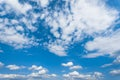

--------------------------------------------------------------------------------
Response:
********************************************************************************
The color of the sky on a typical clear day is blue. This is due to the scattering of sunlight by the atmosphere, where shorter wavelengths of light (blue) are scattered more than longer wavelengths (red). This effect is known as Rayleigh scattering. The image you provided shows a blue sky with some white clouds, which is representative of a typical sunny day.


In [ ]:
chat.reset()
chat.ask("On a typical day, what is the color of the sky?")

#### Slightly Harder

I noticed the sample of LAION we uploaded contained a lot of pulp fiction posters - let's see what the model can tell us about the movie

Search Results: [{'row_id': '948744495', 'body_blob': 'film de quentin tarantino pulp fiction images pulp fiction hd wallpaper and', 'distance': 0.6237166122198347}, {'row_id': '879328613', 'body_blob': 'Pulp Fiction One Sheet', 'distance': 0.6220977971750888}, {'row_id': '925601105', 'body_blob': 'Image of Pulp Fiction', 'distance': 0.6020597597332322}]
--------------------------------------------------------------------------------
Successfully tokenized IMG 0: http://tse2.mm.bing.net/th?id=OIP.eZugkbELQrylx8gIzqxydQHaEK


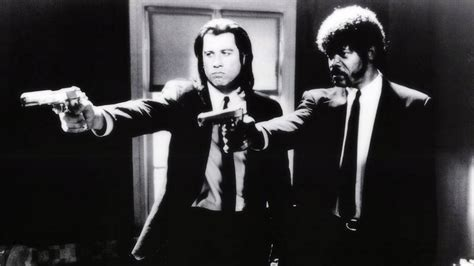

--------------------------------------------------------------------------------
Response:
********************************************************************************
In the image you provided, the characters are dressed in what has become iconic attire from the film "Pulp Fiction." Both characters are wearing black suits with white dress shirts underneath and skinny black ties. This simple yet stylish look became emblematic of the film's cool, retro aesthetic and has since been associated with the film's portrayal of these characters as smooth-talking, sharply dressed hitmen. Throughout the film, their suits play a role in the visual narrative, setting a tone that blends elements of crime noir with 1990s fashion sensibility.


In [ ]:
chat.reset()
chat.ask("What are some fun suits from Pulp Fiction?")

Pretty cool, the model was able to augment knowledge it already had about Pulp Fiction with the image provided.

#### Questions that Require Specific Knowledge

It did pretty well on the simple questions! Now though, let's ask it a question it doesn't have the proper context to answer (I'll include a few different completions).

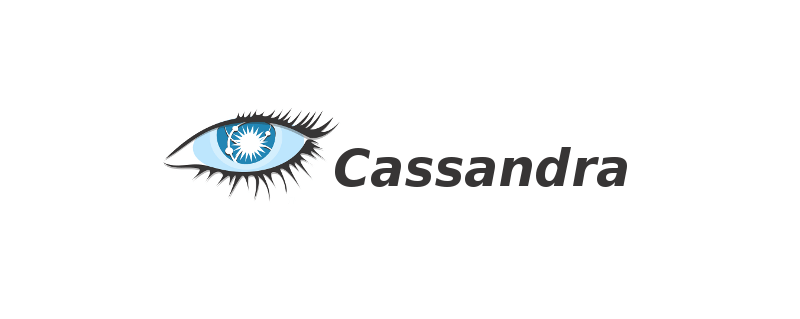

In [ ]:
# Actual Apache Cassandra logo for reference
img_from_url("https://i0.wp.com/blog.knoldus.com/wp-content/uploads/2018/08/cassandra.png")

In [ ]:
for ndx in range(3):
    chat.reset()
    print(f"Completion {ndx}\n")
    chat.ask("What does the Apache Cassandra logo look like?")
    print("\n" * 2)

Completion 0

Search Results: [{'row_id': '1689228614', 'body_blob': 'Big Data development', 'distance': 0.5926132512152685}, {'row_id': '1712369354', 'body_blob': 'Hadoop article', 'distance': 0.5872599482883503}, {'row_id': '1781783515', 'body_blob': 'Build a Full Big Data Platform Right Away?', 'distance': 0.5783575039232787}]
--------------------------------------------------------------------------------
No images closer than threshold 0.60, running text-only query
--------------------------------------------------------------------------------
Response:
********************************************************************************
The Apache Cassandra logo consists of a stylized letter "C" in a blue and white color scheme, with the bottom part of the "C" resembling a forward slash. The logo also includes the name "Cassandra" in a modern sans-serif font next to the "C" symbol. The overall design is simple and clean, reflecting the database's focus on efficiency and scalability.


#### Adding the Proper Context

An LLM can only be as good as the knowledge it has access to. Here, we add information to our Astra DB vector store that could answer the above user question. We embed and store a version of the Apache Cassandra logo, then ask the RAG-Chat model the same question once again.

In [ ]:
chat.embed_and_store_image(
    url="https://i0.wp.com/blog.knoldus.com/wp-content/uploads/2018/08/cassandra.png",
    caption="Apache Cassandra logo",
)

'73d97e41-8bf9-46ad-a43a-c18191046ba1'

Search Results: [{'row_id': '73d97e41-8bf9-46ad-a43a-c18191046ba1', 'body_blob': 'Apache Cassandra logo', 'distance': 0.6601373138784513}, {'row_id': '1689228614', 'body_blob': 'Big Data development', 'distance': 0.5926132512152685}, {'row_id': '1712369354', 'body_blob': 'Hadoop article', 'distance': 0.5872599482883503}]
--------------------------------------------------------------------------------
Successfully tokenized IMG 0: https://i0.wp.com/blog.knoldus.com/wp-content/uploads/2018/08/cassandra.png


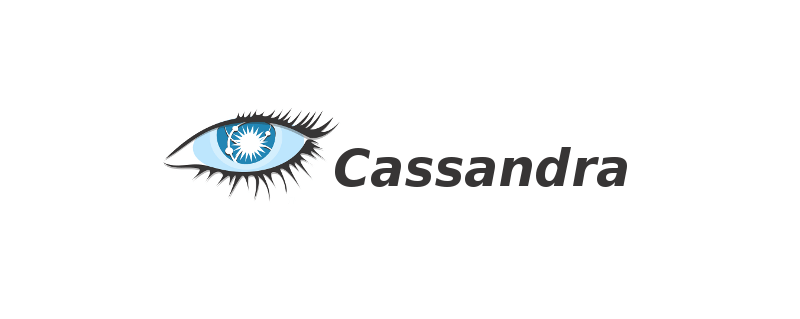

--------------------------------------------------------------------------------
Response:
********************************************************************************
The Apache Cassandra logo in the image depicts a stylized eye with a striking blue iris and what appears to be a white data symbol in the center, suggesting the idea of vision or insight into data. The word "Cassandra" is written in a simple, modern sans-serif typeface to the right of the eye graphic. The logo represents the open-source distributed NoSQL database system, known for handling large amounts of data across many commodity servers, providing high availability with no single point of failure.


In [ ]:
chat.reset()
chat.ask("What does the Apache Cassandra logo look like?")

#### Final Thoughts

Adding RAG to multimodal models is a good way to augment the model with context that it may need to be effective in a real-world use case. In this demo we show examples of just giving the model extra visual context from your individual/proprietary data, but we can imagine some easily extendable use cases as well:
- Appending both text and/or image context for a given query based on some routing models or hardcoded logic in the application
- Finding in-context few shot image examplars to guide few shot classification (see the [OpenFlamingo demo](https://huggingface.co/spaces/openflamingo/OpenFlamingo))
- Finding in-context few shot exemplars to guide image generation for diffusion models (see [CM3Leon](https://arxiv.org/abs/2309.02591))

All in all, these large models can only be as useful as the data they have seen, and that includes multimodal models. Adding RAG to multimodal models of all varieties can lead to some huge accuracy improvements, and greater efficacy of your application. And Astra DB makes this not only possible, but quick and easy to implement.